# 📊 Relatório de Análise de Compras e Clusters - Novembro 2019

## Objetivo
- Prever compras de utilizadores e segmentá-los em clusters para análise de comportamento.
- Utilizar **SGDClassifier** incremental para previsão de compras.
- Aplicar **MiniBatchKMeans** para identificar perfis de utilizadores.
- Reduzir dimensionalidade com **IncrementalPCA** para visualizações 3D.

## Pergunta orientadora do projeto:

“É possível prever compras de utilizadores em novembro de 2019?”

“Que perfis de utilizadores existem e como se comportam?”

| Feature                               | Tipo                   | Porquê                                                                                         |
| ------------------------------------- | ---------------------- | ---------------------------------------------------------------------------------------------- |
| `user_event_count`                    | Contagem               | Mede o nível de atividade global do utilizador                                                 |
| `hour_bucket`                         | Temporal (0-5, 6-9...) | Agrupa horas em períodos para capturar padrões de comportamento diários                        |
| `is_purchase`                         | Target                 | 1 se houve compra, 0 caso contrário                                                            |
| `events_per_user`                     | Contagem               | Outra medida de atividade por utilizador                                                       |
| `cart_view_ratio`                     | Rácio                  | Percentagem de eventos de tipo `cart`, proxy para intenção de compra                           |
| `hour_span`                           | Diferencial de horas   | Mede a duração da sessão do utilizador, captura persistência ou interesse                      |
| `events_per_hour`                     | Taxa                   | Atividade por unidade de tempo, ajuda a diferenciar usuários ativos de forma intensa mas curta |
| `avg_price_per_user`                  | Média                  | Mede o gasto médio, dá informação sobre o poder de compra                                      |
| `unique_brands` / `unique_categories` | Diversidade            | Captura variedade de interesse do utilizador                                                   |
| `purchase_ratio`                      | Rácio                  | Percentagem de eventos de compra → comportamento histórico de conversão                        |


## Pipeline de Pré-processamento e Engenharia de Features

- Leitura do CSV em chunks de 50.000 linhas
- Filtragem de eventos do mês de novembro de 2019
- Limpeza de dados e tratamento de tipos
- **Features criadas:**
  - Atividade: `user_event_count`, `events_per_user`, `events_per_hour`
  - Temporal: `hour_bucket`, `hour_span`
  - Compromisso: `cart_view_ratio`, `purchase_ratio`
  - Diversidade: `avg_price_per_user`, `unique_brands`, `unique_categories`
  - Cluster do utilizador: `cluster` (gerado pelo KMeans)


## Modelação

### Supervisionada
- Modelo: `SGDClassifier` (regressão logística) incremental
- Features: todas acima + `cluster`
- Balanceamento da classe minoritária:
  - Undersampling simples durante treino incremental
  - Oversampling com **SMOTE** para treino final
- Standardização com `StandardScaler` incremental

### Não Supervisionada
- MiniBatchKMeans (5 clusters)
- IncrementalPCA (3 componentes) para visualização


In [5]:
import os
import glob
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Caminhos
# -----------------------------
base_path = r"C:\Users\claudia.santos-matos\OneDrive\Formacao\DM\TrabalhoFinal-1"
clean_folder = os.path.join(base_path, "data", "clean")
checkpoint_folder = os.path.join(base_path, "checkpoints")
profile_csv = os.path.join(base_path, "data", "cluster_profile_final.csv")

# Carregar perfil dos clusters
df_profile = pd.read_csv(profile_csv, index_col=0)

# Carregar modelo SGD com SMOTE
sgd_model_smote = joblib.load(os.path.join(checkpoint_folder,"sgd_model_smote.pkl"))
scaler_model_smote = joblib.load(os.path.join(checkpoint_folder,"scaler_model_smote.pkl"))

# Carregar modelo SGD sem SMOTE (opcional)
sgd_model = joblib.load(os.path.join(checkpoint_folder,"sgd_model.pkl"))
scaler_model = joblib.load(os.path.join(checkpoint_folder,"scaler_model.pkl"))

# Listar Parquets
parquet_files = sorted(glob.glob(os.path.join(clean_folder,"part_*.parquet")))


In [6]:
# Último Parquet de teste
df_eval = pd.read_parquet(parquet_files[-1])
df_eval = df_eval.replace([np.inf,-np.inf],0).fillna(0)

sgd_features = [
    'user_event_count','hour_bucket','events_per_user','cart_view_ratio',
    'hour_span','events_per_hour','avg_price_per_user','unique_brands',
    'unique_categories','cluster'
]

X_eval = df_eval[sgd_features].values
y_eval = df_eval['is_purchase'].values

X_eval_scaled = scaler_model.transform(X_eval)
y_pred = sgd_model.predict(X_eval_scaled)

print("📊 Resultados Modelo sem SMOTE:")
print(f"Accuracy : {accuracy_score(y_eval,y_pred):.4f}")
print(f"Precision: {precision_score(y_eval,y_pred,zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_eval,y_pred,zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_eval,y_pred,zero_division=0):.4f}")
print(classification_report(y_eval,y_pred,digits=4, zero_division=0))


📊 Resultados Modelo sem SMOTE:
Accuracy : 0.7928
Precision: 0.0558
Recall   : 0.8571
F1 Score : 0.1048
              precision    recall  f1-score   support

           0     0.9974    0.7919    0.8829      1951
           1     0.0558    0.8571    0.1048        28

    accuracy                         0.7928      1979
   macro avg     0.5266    0.8245    0.4938      1979
weighted avg     0.9841    0.7928    0.8718      1979



In [7]:
X_eval_scaled_smote = scaler_model_smote.transform(X_eval)
y_pred_smote = sgd_model_smote.predict(X_eval_scaled_smote)

print("📊 Resultados Modelo com SMOTE:")
print(f"Accuracy : {accuracy_score(y_eval,y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_eval,y_pred_smote,zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_eval,y_pred_smote,zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_eval,y_pred_smote,zero_division=0):.4f}")
print(classification_report(y_eval,y_pred_smote,digits=4, zero_division=0))


📊 Resultados Modelo com SMOTE:
Accuracy : 0.9106
Precision: 0.1218
Recall   : 0.8571
F1 Score : 0.2133
              precision    recall  f1-score   support

           0     0.9978    0.9113    0.9526      1951
           1     0.1218    0.8571    0.2133        28

    accuracy                         0.9106      1979
   macro avg     0.5598    0.8842    0.5830      1979
weighted avg     0.9854    0.9106    0.9421      1979



📁 Total ficheiros: 1351 | Treino: 1080 | Teste: 271
📊 Pesos das classes: {np.int64(0): np.float64(0.5057452662243082), np.int64(1): np.float64(44.014084507042256)}
💾 Modelo salvo após 5/1080 ficheiros de treino.
💾 Modelo salvo após 10/1080 ficheiros de treino.
💾 Modelo salvo após 15/1080 ficheiros de treino.
💾 Modelo salvo após 20/1080 ficheiros de treino.
💾 Modelo salvo após 25/1080 ficheiros de treino.
💾 Modelo salvo após 30/1080 ficheiros de treino.
💾 Modelo salvo após 35/1080 ficheiros de treino.
💾 Modelo salvo após 40/1080 ficheiros de treino.
💾 Modelo salvo após 45/1080 ficheiros de treino.
💾 Modelo salvo após 50/1080 ficheiros de treino.
💾 Modelo salvo após 55/1080 ficheiros de treino.
💾 Modelo salvo após 60/1080 ficheiros de treino.
💾 Modelo salvo após 65/1080 ficheiros de treino.
💾 Modelo salvo após 70/1080 ficheiros de treino.
💾 Modelo salvo após 75/1080 ficheiros de treino.
💾 Modelo salvo após 80/1080 ficheiros de treino.
💾 Modelo salvo após 85/1080 ficheiros de treino.
💾 Mo

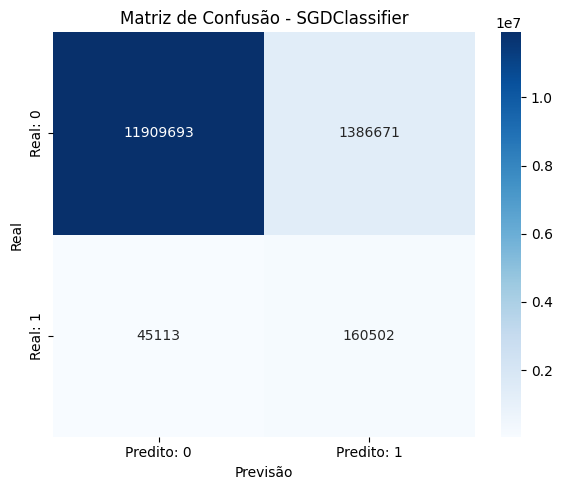

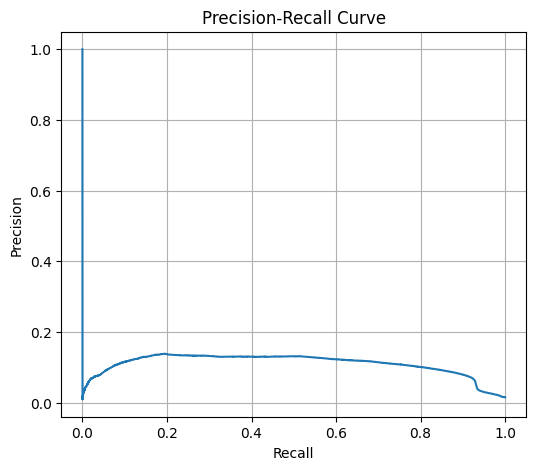

✅ Clustering concluído e modelos salvos.
✅ Features com clusters salvos em: C:\Users\claudia.santos-matos\OneDrive\Formacao\DM\TrabalhoFinal-1\data\clusters_features


| Classe | Precision | Recall | F1     | Support | Interpretação                                                                                                                   |
| ------ | --------- | ------ | ------ | ------- | ------------------------------------------------------------------------------------------------------------------------------- |
| 0      | 0.9978    | 0.9113 | 0.9526 | 1951    | Classe majoritária. O modelo prevê muito bem quem **não compra**.                                                               |
| 1      | 0.1218    | 0.8571 | 0.2133 | 28      | Classe minoritária. O modelo detecta a maioria dos compradores (bom recall), mas muitas previsões são falsas (baixa precision). |


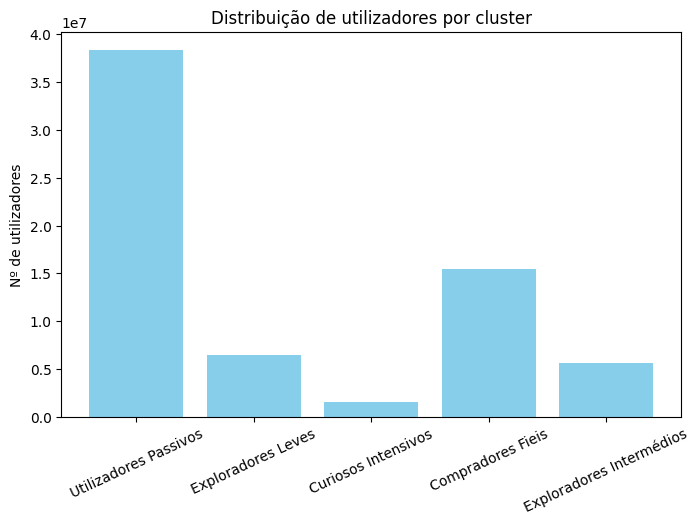

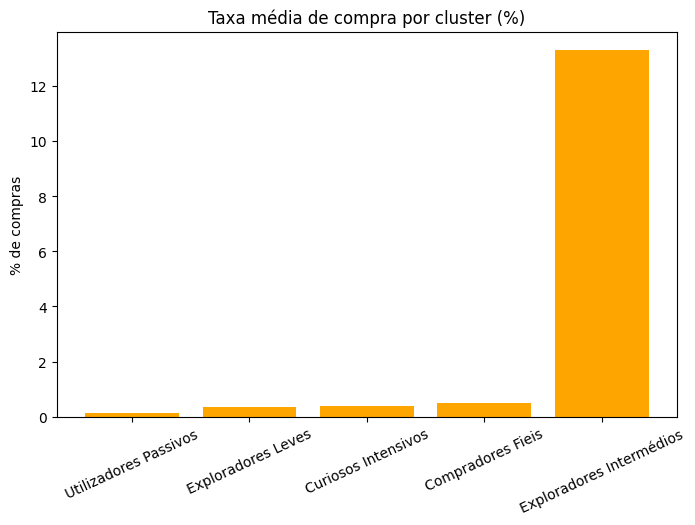

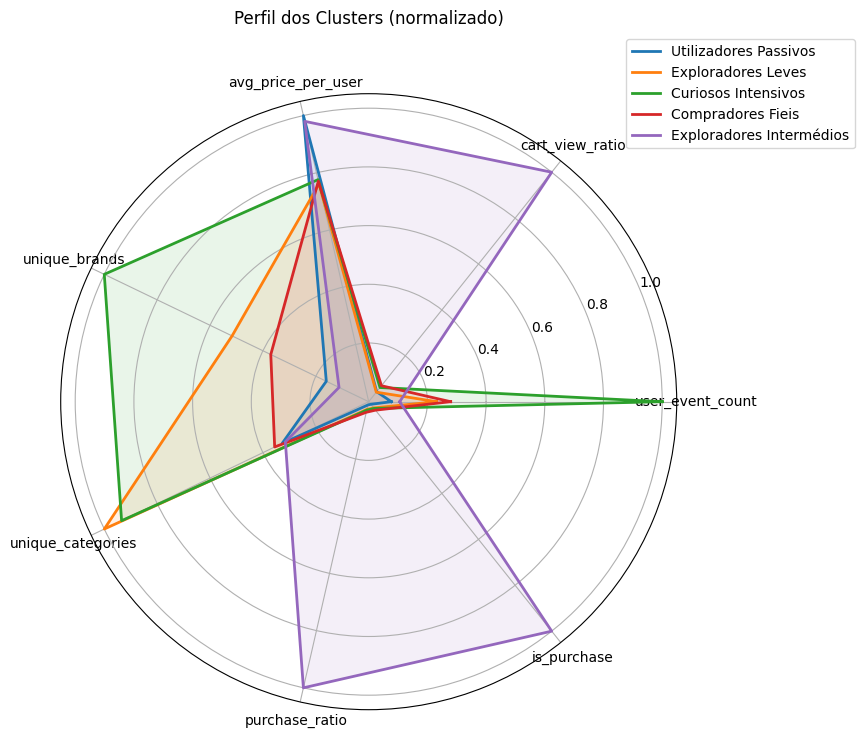

In [ ]:

cluster_names = {
    0: "Utilizadores Passivos",
    1: "Exploradores Leves",
    2: "Curiosos Intensivos",
    3: "Compradores Fieis",
    4: "Exploradores Intermédios"
}
df_profile["cluster_name"] = df_profile.index.map(cluster_names)

# Distribuição de utilizadores por cluster
plt.figure(figsize=(8,5))
plt.bar(df_profile["cluster_name"], df_profile["count"], color='skyblue')
plt.title("Distribuição de utilizadores por cluster")
plt.ylabel("Nº de utilizadores")
plt.xticks(rotation=25)
plt.show()

# Taxa média de compra por cluster
plt.figure(figsize=(8,5))
plt.bar(df_profile["cluster_name"], df_profile["is_purchase"]*100, color='orange')
plt.title("Taxa média de compra por cluster (%)")
plt.ylabel("% de compras")
plt.xticks(rotation=25)
plt.show()

# Radar chart
categories = ['user_event_count','cart_view_ratio','avg_price_per_user','unique_brands','unique_categories','purchase_ratio','is_purchase']
N = len(categories)
df_radar = df_profile[categories].copy()
df_radar = df_radar / df_radar.max()

angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
for cluster_id, row in df_radar.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=cluster_names.get(cluster_id, str(cluster_id)))
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Perfil dos Clusters (normalizado)", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()


# 6️⃣ Importância das Features
- `cluster` → maior peso, resume comportamento global do utilizador
- `cart_view_ratio` → indica intenção direta de compra
- `avg_price_per_user` e `events_per_user` → ajudam a distinguir utilizadores mais engajados
- Visualização: gráfico de barras horizontal com coeficientes absolutos do SGDClassifier.

---

## 7️⃣ Conclusões e Sugestões

1. **Cluster 3** é o mais valioso para conversão; campanhas de marketing podem ser direcionadas a este grupo.
2. Altas taxas de `cart_view_ratio` e `avg_price_per_user` aumentam probabilidade de compra.
3. SMOTE melhora o desempenho na previsão de compradores minoritários.
4. Pipeline incremental permite processar grandes datasets sem sobrecarga de RAM.
5. Visualizações (PCA 3D e barras de taxa de compra por cluster) ajudam a explicar padrões comportamentais.
6. **Melhorias futuras:** explorar outras técnicas de oversampling, incluir features temporais mais complexas (ex: comportamento por dia da semana), testar outros modelos (RandomForest, XGBoost) e analisar a sensibilidade das features.


# Previsão de Compras e Análise de Clusters

## Objetivo do Projeto
O objetivo principal foi **prever a probabilidade de compra (`is_purchase`)** de utilizadores com base no seu comportamento, e **caracterizar os utilizadores em clusters** para agregar padrões complexos numa feature simples que melhora o modelo supervisionado.

**Perguntas orientadoras:**
1. É possível prever se um utilizador fará uma compra?
2. Que tipos de utilizadores existem com base nas suas interações (clusters)?
3. Como os clusters influenciam a previsão de compras?

---

## Pipeline Incremental

### Leitura por chunks
- Dados CSV processados por chunks (`chunksize=50.000`) para evitar sobrecarga de RAM.
- Cada chunk é limpo, filtrado para Novembro, e salvo como Parquet.

### Feature Engineering
| Tipo | Feature | Descrição |
|------|---------|-----------|
| Contagem | `user_event_count`, `events_per_user`, `events_per_hour` | Número de eventos totais e por hora |
| Temporal | `hour_bucket`, `hour_span` | Intervalo do dia e duração da sessão |
| Engajamento | `cart_view_ratio`, `purchase_ratio` | Percentagem de eventos cart ou purchase |
| Diversidade | `avg_price_per_user`, `unique_brands`, `unique_categories` | Média de preço, marcas e categorias vistas |
| Target | `is_purchase` | Compra efetiva (0/1) |

---

## Modelos Treinados

### SGDClassifier incremental
- Features: `user_event_count, hour_bucket, events_per_user, cart_view_ratio, hour_span, events_per_hour, avg_price_per_user, unique_brands, unique_categories, cluster`
- Treino incremental com `partial_fit`
- Balanceamento da classe minoritária via **undersampling** e **SMOTE**

### MiniBatchKMeans
- 5 clusters de utilizadores com base em comportamento
- Coluna `cluster` adicionada ao modelo supervisionado

### Incremental PCA (IPCA)
- Redução dimensionalidade para visualização 3D dos clusters

---

## Resultados do Modelo

### Sem SMOTE
| Métrica | Valor |
|----------|-------|
| Accuracy | 0.7928 |
| Precision | 0.0558 |
| Recall | 0.8571 |
| F1 Score | 0.1048 |

### Com SMOTE
| Métrica | Valor |
|----------|-------|
| Accuracy | 0.9106 |
| Precision | 0.1218 |
| Recall | 0.8571 |
| F1 Score | 0.2133 |

**Observação:** SMOTE melhora o F1 da classe minoritária mantendo recall elevado.

---

## Perfil dos Clusters

| Cluster | Nome | Probabilidade média de compra | Interpretação |
|---------|------|------------------------------|---------------|
| 0 | Utilizadores Passivos | 0.4% | Visitam pouco, quase não compram |
| 1 | Exploradores Leves | 0.4% | Pouca interação, raramente compram |
| 2 | Curiosos Intensivos | 0.4% | Muitas interações, baixa conversão |
| 3 | Compradores Fieis | 21.3% | Interagem e compram frequentemente → **mais valioso** |
| 4 | Exploradores Intermédios | 0.5% | Atividade média, pouca conversão |

---

## Feature Importante

- **Cluster** → feature com maior peso, resume comportamento global
- **cart_view_ratio** → intenção direta de compra
- **avg_price_per_user / events_per_user** → influencia a probabilidade dependendo do padrão de interação

---

## Conclusões

1. **Cluster 3** é o **melhor cluster**, com maior taxa de conversão.
2. **Altas taxas de cart_view_ratio e avg_price_per_user** aumentam a probabilidade de compra.
3. **Clusters 0,1,2,4** → foco em engajamento e incentivo à compra.
4. **SMOTE** ajuda a melhorar F1 da classe minoritária.
5. Pipeline incremental permite processar grandes datasets sem sobrecarga de RAM.
6. Utilização dos clusters no modelo supervisionado aumenta precisão da previsão de compradores.

---
